In [128]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd # Often needed, good to import
import pickle
import logging # For informative messages
from pathlib import Path
import random
import os

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go # Used later for plots

# Neuroimaging/ML Libraries
import nilearn.datasets
import nilearn.plotting # Used later for connectomes

# Network Analysis
import networkx as nx # Used later for graphs

# Stats (if needed, e.g., for efficiency comparison)
from scipy import stats

# --- Project Modules ---
# Add src to sys.path (ensure this logic is correct for your structure)
import sys
SRC_DIR = Path.cwd().parent / 'src'
if SRC_DIR not in sys.path:
    sys.path.append(str(SRC_DIR))

from file_utils import load_pickle, pickle_file
from matrix_utils import vector_to_symmetric_matrix # Use the new name
from network_utils import (
    get_network_indices,
    GraphFromConnectivity, # Use the new name
    parcel_names_to_indices,
    get_correlation_indices,
)
from plotting_utils import (
    get_network_rgba, plot_permutation_distribution, 
    plot_degree_centrality_violins, plot_efficiency_violins, 
    plot_community_connectome, plot_connectivity_heatmap,
    plot_network_radar
)
from stats_utils import get_permutation_pvalue # If needed
from modeling_utils import get_distances, find_optimal_clf_threshold
from data_utils import get_coord_from_df, get_index_from_df, get_description_from_df # If using stanford_df lookup
from network_analysis import create_run_level_graphs, calculate_degree_centrality, calculate_efficiency, detect_communities_on_average

# --- Setup Logging ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Set Seeds (Optional but good practice) ---
SEED = 123 # Choose a seed
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f"Using random seed: {SEED}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using random seed: 123


### CONFIGURATION

In [129]:
# --- Core Project Structure ---
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
MODELS_DIR = BASE_DIR / "models"
REPORTS_DIR = BASE_DIR / "reports"
FIGURE_DIR = REPORTS_DIR / "figures"
ANALYSIS_RESULTS_DIR = REPORTS_DIR / "analysis_results" # For CSVs, pickles etc.

# --- Specific Input Files ---
# Processed FC data (output from data loading in notebook 1 or elsewhere)
FC_DATA_NPZ = INTERIM_DATA_DIR / "functional_connectivity_processed.npz"

# Saved multi-class models (Output from notebook 1)
# Select ONE model file to analyze, or adjust logic later to loop through models
MULTICLASS_MODEL_PKL = MODELS_DIR / "threeclass_onevrest_classifier_weights.pkl"
# MULTICLASS_MODEL_PKL = MODELS_DIR / "threeclass_onevone_classifier_weights.pkl"

# --- Output Locations ---
NETWORK_ANALYSIS_DIR = ANALYSIS_RESULTS_DIR / "network_analysis"
DEGREE_CENTRALITY_DIR = ANALYSIS_RESULTS_DIR / "degree_centrality" / "threeclass" # Subdir based on original path
NETWORK_FIGURE_DIR = FIGURE_DIR / "network_analysis" # Specific subdir for these figures
# Create output directories
NETWORK_ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)
DEGREE_CENTRALITY_DIR.mkdir(parents=True, exist_ok=True)
NETWORK_FIGURE_DIR.mkdir(parents=True, exist_ok=True)

MULTICLASS_LABELS = ['HC', 'Cannabis', 'Alcohol']

In [130]:
# --- Analysis Parameters ---
N_ROIS = 100 # Number of regions in the atlas
ATLAS_NAME = "schaefer_2018" # Name of the atlas used
YEO_NETWORKS = 7 # Number of Yeo networks for Schaefer atlas
RESOLUTION_MM = 2 # Atlas resolution

# Threshold for community detection and graph creation (percentile)
COMM_THRESHOLD_PERC = 98

# Model selection for detailed analysis/plotting (used in several later cells)
# This might need adjustment if analyzing OVO and OVR results requires different models
SELECTED_MODEL_KEY = 'OVR_L2_logistic' # Key within the loaded models dictionary

# Indices for plotting specific parcels in DC plots (example values from notebook)
SELECTED_IND_DC = np.hstack([np.arange(2), np.arange(80, 100)])

In [131]:
# --- Verification ---
print(f"Project Base Directory: {BASE_DIR}")
print(f"Reading FC data from: {FC_DATA_NPZ}")
print(f"Reading Models from: {MULTICLASS_MODEL_PKL}")
print(f"Saving Network Analysis results to: {NETWORK_ANALYSIS_DIR}")
print(f"Saving Network Figures to: {NETWORK_FIGURE_DIR}")
print(f"ROI Count: {N_ROIS}")
print(f"Community Threshold: {COMM_THRESHOLD_PERC}%")

# Check if key input files exist
if not FC_DATA_NPZ.is_file():
     logging.warning(f"Input FC data file NOT FOUND: {FC_DATA_NPZ}")
if not MULTICLASS_MODEL_PKL.is_file():
     logging.warning(f"Input model file NOT FOUND: {MULTICLASS_MODEL_PKL}")

Project Base Directory: /Users/kulkarnik/LocalProjects/multiclassifier_repo
Reading FC data from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz
Reading Models from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/threeclass_onevrest_classifier_weights.pkl
Saving Network Analysis results to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis
Saving Network Figures to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis
ROI Count: 100
Community Threshold: 98%


### GENERATE WEIGHTED FCS

In [132]:
# --- Load Processed FC Data and Combine ---

print(f"Loading processed FC data from: {FC_DATA_NPZ}")
fcs_list = []
labels_list = []
sub_names_list = []

try:
    with np.load(FC_DATA_NPZ) as infile:
        print(f"  Available keys in npz file: {list(infile.keys())}")

        # Load Alcohol Data (if present)
        if 'alcohol_fcs' in infile and infile['alcohol_fcs'].size > 0:
            print(f"  Loading Alcohol data (shape: {infile['alcohol_fcs'].shape})")
            fcs_list.append(infile['alcohol_fcs'])
            labels_list.append(infile['alcohol_labels'])
            sub_names_list.append(infile['alcohol_sub_names'])
            # if 'alcohol_run_ids' in infile: run_ids_list.append(infile['alcohol_run_ids'])
            # if 'alcohol_training' in infile: training_list.append(infile['alcohol_training'])
        else:
            print("  Alcohol data not found or empty in npz file.")

        # Load Cannabis Data (if present)
        if 'cannabis_fcs' in infile and infile['cannabis_fcs'].size > 0:
            print(f"  Loading Cannabis data (shape: {infile['cannabis_fcs'].shape})")
            fcs_list.append(infile['cannabis_fcs'])
            labels_list.append(infile['cannabis_labels'])
            sub_names_list.append(infile['cannabis_sub_names'])
            # if 'cannabis_run_ids' in infile: run_ids_list.append(infile['cannabis_run_ids'])
            # if 'cannabis_training' in infile: training_list.append(infile['cannabis_training'])
        else:
            print("  Cannabis data not found or empty in npz file.")

        # Check if any data was loaded
        if not fcs_list:
            raise ValueError("No valid FC data loaded from the npz file.")

        # Concatenate the loaded data
        fcs = np.concatenate(fcs_list, axis=0)
        labels = np.concatenate(labels_list, axis=0)
        sub_names = np.concatenate(sub_names_list, axis=0)
        # if run_ids_list: run_ids = np.concatenate(run_ids_list, axis=0)
        # if training_list: training = np.concatenate(training_list, axis=0)

        print("\nConcatenated Data Shapes:")
        print(f"  fcs: {fcs.shape}")
        print(f"  labels: {labels.shape}")
        print(f"  sub_names: {sub_names.shape}")
        # if 'run_ids' in locals(): print(f"  run_ids: {run_ids.shape}")
        # if 'training' in locals(): print(f"  training: {training.shape}")

except FileNotFoundError:
    raise FileNotFoundError(f"Input FC data file not found at {FC_DATA_NPZ}. Ensure notebook 1 saved it correctly.")
except Exception as e:
    raise RuntimeError(f"Failed to load or process {FC_DATA_NPZ}: {e}")


# --- Load Models ---
print(f"\nLoading models from {MULTICLASS_MODEL_PKL}")
try:
    # This loads the dictionary of models saved by MultiClassEvaluator
    # Keys are like 'OVR_L1_logistic', 'OVO_L2_LinearSVC', etc.
    all_fitted_models = load_pickle(MULTICLASS_MODEL_PKL) # Using function from src/file_utils
    print(f"  Loaded models for keys: {list(all_fitted_models.keys())}")
except Exception as e:
    raise RuntimeError(f"Failed to load models from {MULTICLASS_MODEL_PKL}: {e}")

print("\nModel loading complete. Weight extraction will occur during WFC calculation.")

2025-04-21 16:15:15,985 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/threeclass_onevrest_classifier_weights.pkl


Loading processed FC data from: /Users/kulkarnik/LocalProjects/multiclassifier_repo/data/interim/functional_connectivity_processed.npz
  Available keys in npz file: ['alcohol_fcs', 'alcohol_labels', 'alcohol_sub_names', 'alcohol_training', 'cannabis_fcs', 'cannabis_labels', 'cannabis_sub_names', 'cannabis_training']
  Loading Alcohol data (shape: (320, 4950))
  Loading Cannabis data (shape: (411, 4950))

Concatenated Data Shapes:
  fcs: (731, 4950)
  labels: (731,)
  sub_names: (731,)

Loading models from /Users/kulkarnik/LocalProjects/multiclassifier_repo/models/threeclass_onevrest_classifier_weights.pkl
  Loaded models for keys: ['OVR_L1_logistic', 'OVR_L2_logistic', 'OVR_L1_LinearSVC', 'OVR_L2_LinearSVC']

Model loading complete. Weight extraction will occur during WFC calculation.


In [133]:
# Get Atlas Info
print("Fetching Schaefer Atlas information...")
schaefer_atlas = nilearn.datasets.fetch_atlas_schaefer_2018(
    n_rois=N_ROIS,
    yeo_networks=YEO_NETWORKS,
    resolution_mm=RESOLUTION_MM
)
# Clean up parcel names (remove '7Networks_' prefix if desired, depends on subsequent usage)
# Assuming subsequent code expects names like 'Vis_1', 'SomMot_1' etc.
raw_labels = schaefer_atlas['labels'].astype(str)
parcel_names = ['_'.join(label.split('_')[1:]) for label in raw_labels]
print(f"  Loaded {len(parcel_names)} parcel names.")
# Create network indices mapping
network_inds = get_network_indices(parcel_names, delimiter='_', network_part_index=1) # Index 1 after splitting 'Vis_1'
print(f"  Generated network indices for: {list(network_inds.keys())}")

# Get Network Colors
network_rgba_tuple, network_rgba_str_list = get_network_rgba(network_inds, N_ROIS)
print("\nGenerated network RGBA colors.")

Fetching Schaefer Atlas information...
  Loaded 100 parcel names.
  Generated network indices for: ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

Generated network RGBA colors.


In [134]:
# Calculate Weighted Functional Connectivity (WFC)

print("Calculating Weighted Functional Connectivity...")
vector_size = fcs.shape[1] # Should match N_ROIS*(N_ROIS-1)//2
run_wfc = {} # Dictionary to store WFC per model variant and class comparison

# Assuming all_fitted_models contains the dict loaded from pickle
for model_key, multiclass_wrapper in all_fitted_models.items():
    if not hasattr(multiclass_wrapper, 'estimators_') or not multiclass_wrapper.estimators_:
        print(f"Skipping WFC for {model_key}: No base estimators found.")
        continue

    run_wfc[model_key] = {}
    # Assuming estimators correspond to HC, Cannabis, Alcohol vs Rest
    class_labels_ordered = MULTICLASS_LABELS # From config

    if len(multiclass_wrapper.estimators_) != len(class_labels_ordered):
         print(f"Warning: Number of estimators in {model_key} ({len(multiclass_wrapper.estimators_)}) doesn't match MULTICLASS_LABELS ({len(class_labels_ordered)}). Using indices.")
         class_labels_ordered = [f"Estimator_{i}" for i in range(len(multiclass_wrapper.estimators_))]


    for i, base_estimator in enumerate(multiclass_wrapper.estimators_):
        group_name = class_labels_ordered[i]
        if hasattr(base_estimator, 'coef_'):
             weights = base_estimator.coef_[0] # Assumes shape (1, n_features)
             if weights.shape[0] != vector_size:
                  print(f"  Weight mismatch for {model_key} - {group_name}. Skipping.")
                  continue
             # Calculate element-wise product for each run's FC vector
             # Use broadcasting for efficiency: weights * fcs (element-wise)
             wfc_vectors = np.abs(weights * fcs) # Shape: (n_runs, n_features)
             run_wfc[model_key][group_name] = wfc_vectors
             print(f"  Calculated WFC for {model_key} - {group_name} vs Rest. Shape: {wfc_vectors.shape}")

        else:
             print(f"  Skipping {model_key} - {group_name}: Base estimator lacks 'coef_'.")

if not run_wfc:
    raise RuntimeError("Failed to calculate WFC for any model/group.")

# Verify shape (using the selected model and first group for example)
first_model_key = list(run_wfc.keys())[0]
first_group_key = list(run_wfc[first_model_key].keys())[0]
print(f"Example WFC shape ({first_model_key}/{first_group_key}): {run_wfc[first_model_key][first_group_key].shape}")

Calculating Weighted Functional Connectivity...
  Calculated WFC for OVR_L1_logistic - HC vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L1_logistic - Cannabis vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L1_logistic - Alcohol vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_logistic - HC vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_logistic - Cannabis vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_logistic - Alcohol vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L1_LinearSVC - HC vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L1_LinearSVC - Cannabis vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L1_LinearSVC - Alcohol vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_LinearSVC - HC vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_LinearSVC - Cannabis vs Rest. Shape: (731, 4950)
  Calculated WFC for OVR_L2_LinearSVC - Alcohol vs Rest. Shape: (731, 4950)
Example WFC shape (OVR_L1_logistic/HC): (731, 4950)


Plotting example WFC matrices...


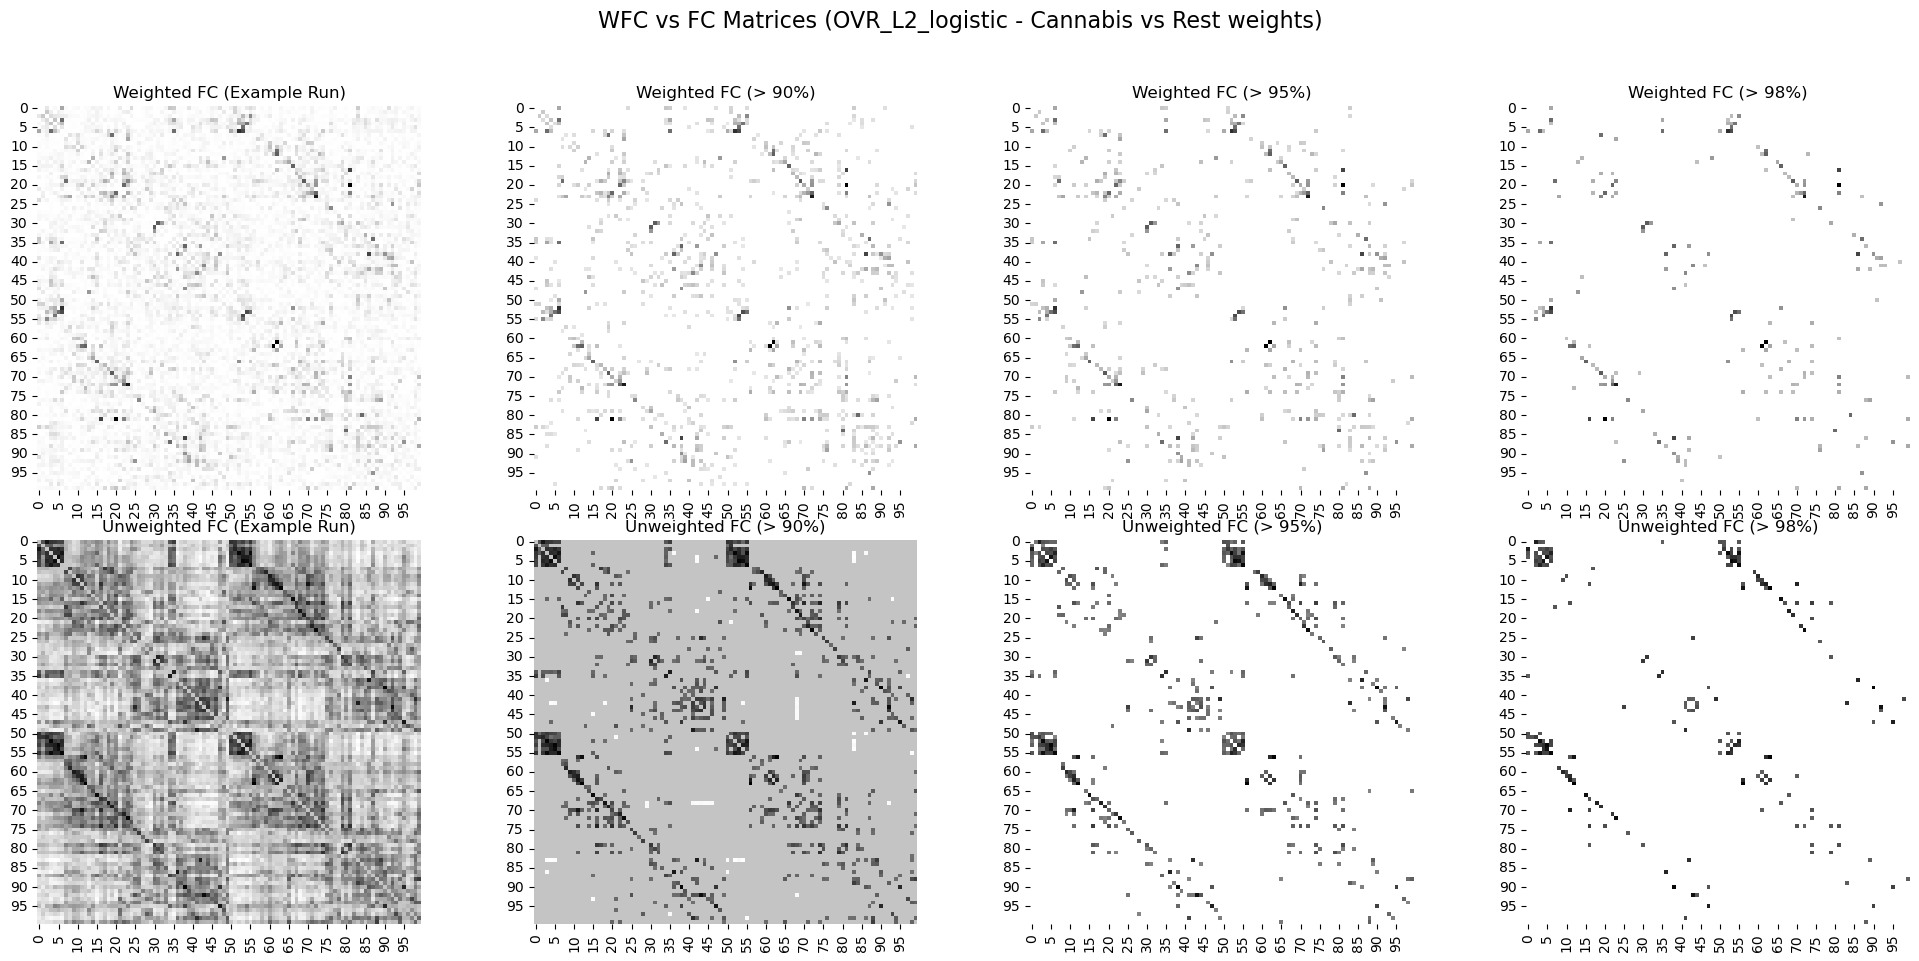

In [135]:
# Plot Example WFC Matrices (Weighted and Thresholded)
print("Plotting example WFC matrices...")

# Use the specific model and group selected in config
# Make sure the selected key/group actually exists in run_wfc
analysis_model_key = SELECTED_MODEL_KEY # e.g., 'OVR_L2_logistic'
analysis_group = MULTICLASS_LABELS[1]    # e.g., 'Cannabis'

# Use the first run's WFC vector for plotting example
wfc_vector_example = run_wfc[analysis_model_key][analysis_group][0]
wfc_matrix_example = vector_to_symmetric_matrix(wfc_vector_example)

# Use the first run's original FC for unweighted comparison
fc_vector_example = fcs[0]
fc_matrix_example = vector_to_symmetric_matrix(fc_vector_example)


fig_heatmap, axs_heatmap = plt.subplots(2, 4, figsize=(20, 10)) # Adjusted size

# Raw matrices
sns.heatmap(wfc_matrix_example, square=True, ax=axs_heatmap[0, 0], cmap='Greys', cbar=False) # Changed cmap
axs_heatmap[0, 0].set_title("Weighted FC (Example Run)")
sns.heatmap(fc_matrix_example, square=True, ax=axs_heatmap[1, 0], cmap='Greys', cbar=False) # Changed cmap
axs_heatmap[1, 0].set_title("Unweighted FC (Example Run)")


# Thresholded matrices (Using percentile from config)
thresholds_to_plot = [90, 95, COMM_THRESHOLD_PERC] # Include config threshold
for i, p_thresh in enumerate(thresholds_to_plot):
    # Weighted Thresholded
    thresh_val_w = np.percentile(wfc_vector_example[wfc_vector_example > 0], p_thresh) # Percentile of non-zero positive weights
    thr_wc = (wfc_matrix_example > thresh_val_w) * wfc_matrix_example
    sns.heatmap(thr_wc, square=True, ax=axs_heatmap[0, i+1], cmap='Greys', cbar=False)
    axs_heatmap[0, i+1].set_title(f"Weighted FC (> {p_thresh}%)")

    # Unweighted Thresholded (use absolute value for thresholding correlations)
    fc_vec_abs = np.abs(fc_vector_example)
    thresh_val_uw = np.percentile(fc_vec_abs[fc_vec_abs > 0], p_thresh)
    thr_uw_fc = (np.abs(fc_matrix_example) > thresh_val_uw) * fc_matrix_example # Keep original signs
    sns.heatmap(thr_uw_fc, square=True, ax=axs_heatmap[1, i+1], cmap='Greys', cbar=False)
    axs_heatmap[1, i+1].set_title(f"Unweighted FC (> {p_thresh}%)")

fig_heatmap.suptitle(f"WFC vs FC Matrices ({analysis_model_key} - {analysis_group} vs Rest weights)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Optionally save figure
# fig_heatmap.savefig(NETWORK_FIGURE_DIR / f"example_wfc_matrices_{analysis_model_key}_{analysis_group}.png", dpi=150)
plt.show()

### GENERATE GRAPHS

In [136]:
# === 1. Create Run-Level Graphs ===
# It creates thresholded graph objects for each run based on the calculated WFC.

print("\n" + "="*40)
print("Starting Graph Creation from WFC")
print("="*40 + "\n")

# --- Verify Input Shapes (Optional but Recommended) ---
# Get expected number of runs from the first WFC entry
if run_wfc:
    first_model_key = list(run_wfc.keys())[0]
    if run_wfc[first_model_key]:
         first_group_key = list(run_wfc[first_model_key].keys())[0]
         expected_runs = run_wfc[first_model_key][first_group_key].shape[0]
         if expected_runs != len(sub_names):
             logging.warning(f"Shape mismatch: WFC runs ({expected_runs}) != number of subject names ({len(sub_names)}). Check data loading/concatenation.")
    else:
        logging.warning("WFC data structure seems empty. Cannot verify shapes.")
else:
     logging.warning("WFC data dictionary 'run_wfc' is empty or not found.")


# --- Create Graphs ---
print(f"Creating graph objects using threshold percentile: {COMM_THRESHOLD_PERC}%")
all_graphs = create_run_level_graphs(
    run_wfc_data=run_wfc,                       # Input WFC data
    parcel_names=parcel_names,                  # List of parcel names
    network_indices=network_inds,               # Mapping of network names to indices
    sub_names_per_run=sub_names,                # Subject ID for each run/row in WFC
    threshold_percentile=COMM_THRESHOLD_PERC    # Threshold from config
)

# --- Verification ---
print("\nGraph creation summary:")
for model_key, group_data in all_graphs.items():
    for group_key, graph_list in group_data.items():
            print(f"  Model '{model_key}', Group '{group_key}': Created {len(graph_list)} graphs.")
# Display info about the first graph object as a sanity check
try:
    first_model_key = list(all_graphs.keys())[0]
    first_group_key = list(all_graphs[first_model_key].keys())[0]
    if all_graphs[first_model_key][first_group_key]:
        first_graph_tuple = all_graphs[first_model_key][first_group_key][0]
        print("\nExample of first graph object created:")
        print(f"  Subject ID: {first_graph_tuple[0]}")
        print(f"  Graph Object: {type(first_graph_tuple[1])}")
        print(f"  Graph Info: {first_graph_tuple[1].graph}") # Display basic networkx info
except Exception as e:
    print(f"\nCould not display example graph info: {e}")


print("\n" + "="*40)
print("Finished Graph Creation")
print("="*40 + "\n")

2025-04-21 16:15:18,873 - INFO - Creating graphs for model: OVR_L1_logistic
2025-04-21 16:15:18,874 - INFO -   Processing group: HC (731 runs)



Starting Graph Creation from WFC

Creating graph objects using threshold percentile: 98%


2025-04-21 16:15:19,822 - INFO -   Processing group: Cannabis (731 runs)
2025-04-21 16:15:20,764 - INFO -   Processing group: Alcohol (731 runs)
2025-04-21 16:15:21,672 - INFO - Creating graphs for model: OVR_L2_logistic
2025-04-21 16:15:21,673 - INFO -   Processing group: HC (731 runs)
2025-04-21 16:15:22,582 - INFO -   Processing group: Cannabis (731 runs)
2025-04-21 16:15:24,252 - INFO -   Processing group: Alcohol (731 runs)
2025-04-21 16:15:25,167 - INFO - Creating graphs for model: OVR_L1_LinearSVC
2025-04-21 16:15:25,168 - INFO -   Processing group: HC (731 runs)
2025-04-21 16:15:26,057 - INFO -   Processing group: Cannabis (731 runs)
2025-04-21 16:15:26,949 - INFO -   Processing group: Alcohol (731 runs)
2025-04-21 16:15:27,852 - INFO - Creating graphs for model: OVR_L2_LinearSVC
2025-04-21 16:15:27,853 - INFO -   Processing group: HC (731 runs)
2025-04-21 16:15:28,774 - INFO -   Processing group: Cannabis (731 runs)
2025-04-21 16:15:29,777 - INFO -   Processing group: Alcohol 


Graph creation summary:
  Model 'OVR_L1_logistic', Group 'HC': Created 731 graphs.
  Model 'OVR_L1_logistic', Group 'Cannabis': Created 731 graphs.
  Model 'OVR_L1_logistic', Group 'Alcohol': Created 731 graphs.
  Model 'OVR_L2_logistic', Group 'HC': Created 731 graphs.
  Model 'OVR_L2_logistic', Group 'Cannabis': Created 731 graphs.
  Model 'OVR_L2_logistic', Group 'Alcohol': Created 731 graphs.
  Model 'OVR_L1_LinearSVC', Group 'HC': Created 731 graphs.
  Model 'OVR_L1_LinearSVC', Group 'Cannabis': Created 731 graphs.
  Model 'OVR_L1_LinearSVC', Group 'Alcohol': Created 731 graphs.
  Model 'OVR_L2_LinearSVC', Group 'HC': Created 731 graphs.
  Model 'OVR_L2_LinearSVC', Group 'Cannabis': Created 731 graphs.
  Model 'OVR_L2_LinearSVC', Group 'Alcohol': Created 731 graphs.

Example of first graph object created:
  Subject ID: M87102083
  Graph Object: <class 'network_utils.GraphFromConnectivity'>
  Graph Info: Graph with 100 nodes and 91 edges

Finished Graph Creation



In [137]:
# === 2. Calculate Mean Weighted Functional Connectivity (WFC) ===
# This cell calculates the average WFC vector across all runs for each
# model and analysis group (e.g., HC vs Rest, Cannabis vs Rest weights).
# This average WFC can be used for visualizations or community detection later.

print("\n" + "="*40)
print("Starting Mean WFC Calculation")
print("="*40 + "\n")

# --- Calculate Mean WFC ---
print("Calculating mean WFC vector per model and group...")
mean_wfc = {}
for model_key, model_groups in run_wfc.items():
    mean_wfc[model_key] = {}
    print(f"  Processing model: {model_key}")
    for group_key, wfc_vectors in model_groups.items():
         print(f"    Processing group: {group_key}")
         if wfc_vectors.size > 0:
              # Calculate mean along the axis corresponding to runs (axis=0)
              mean_wfc[model_key][group_key] = np.mean(wfc_vectors, axis=0)
              print(f"      Calculated mean WFC shape: {mean_wfc[model_key][group_key].shape}")
         else:
              logging.warning(f"      No WFC data for {model_key}/{group_key}. Skipping mean calculation.")
              mean_wfc[model_key][group_key] = np.array([]) # Store empty array


# --- Verification ---
if not mean_wfc or all(not group_data for group_data in mean_wfc.values()):
    logging.warning("Mean WFC calculation failed or resulted in empty data. Check logs.")
else:
    print("\nMean WFC calculation successful. Example shape:")
    try:
        first_mk = list(mean_wfc.keys())[0]
        first_gk = list(mean_wfc[first_mk].keys())[0]
        print(f"  '{first_mk}' / '{first_gk}': {mean_wfc[first_mk][first_gk].shape}")
    except Exception as e:
        print(f"  Could not display example shape: {e}")


print("\n" + "="*40)
print("Finished Mean WFC Calculation")
print("="*40 + "\n")


Starting Mean WFC Calculation

Calculating mean WFC vector per model and group...
  Processing model: OVR_L1_logistic
    Processing group: HC
      Calculated mean WFC shape: (4950,)
    Processing group: Cannabis
      Calculated mean WFC shape: (4950,)
    Processing group: Alcohol
      Calculated mean WFC shape: (4950,)
  Processing model: OVR_L2_logistic
    Processing group: HC
      Calculated mean WFC shape: (4950,)
    Processing group: Cannabis
      Calculated mean WFC shape: (4950,)
    Processing group: Alcohol
      Calculated mean WFC shape: (4950,)
  Processing model: OVR_L1_LinearSVC
    Processing group: HC
      Calculated mean WFC shape: (4950,)
    Processing group: Cannabis
      Calculated mean WFC shape: (4950,)
    Processing group: Alcohol
      Calculated mean WFC shape: (4950,)
  Processing model: OVR_L2_LinearSVC
    Processing group: HC
      Calculated mean WFC shape: (4950,)
    Processing group: Cannabis
      Calculated mean WFC shape: (4950,)
    Pr

### DEGREE CENTRALITY

In [138]:
# === 3. Calculate and Summarize Regional Degree Centrality (DC) ===
# This cell calculates the Degree Centrality for each parcel in each run-level graph,
# then computes the average and standard deviation of DC for each parcel
# across runs, grouped by model and analysis group.
# It saves the summary data and plots violin plots for selected parcels.

print("\n" + "="*40)
print("Starting Regional Degree Centrality Calculation")
print("="*40 + "\n")

# Call the function from src/network_analysis
avg_dc_dfs, std_dc_dfs = calculate_degree_centrality(all_graphs, parcel_names)


# --- Reshape and Save DC Results (Matching Original Structure) ---
# Original structure was {group_key: {model_key: {parcel_name: mean_dc}}}
dc_summary_orig_format = {}
print(f"\nSaving average DC results to {DEGREE_CENTRALITY_DIR}...")
DEGREE_CENTRALITY_DIR.mkdir(parents=True, exist_ok=True) # Ensure the directory exists

# Iterate through the results structure: {model_key: {group_key_internal: DataFrame}}
for model_key, group_avg_dcs in avg_dc_dfs.items():
    # group_avg_dcs is {group_key_internal: DataFrame(index=parcel_name, columns=['Mean DC'])}
    for group_key_internal, avg_dc_df in group_avg_dcs.items():
        # The internal group_key (e.g., 'HC', 'Cannabis', 'Alcohol')
        group_key_external = str(group_key_internal) # Use string key for consistency

        if group_key_external not in dc_summary_orig_format:
            dc_summary_orig_format[group_key_external] = {}

        # Store the Series of Mean DC values (indexed by parcel_names) as a dictionary
        dc_summary_orig_format[group_key_external][model_key] = avg_dc_df['Mean DC'].to_dict()

        # Save to CSV per group (matching original filename pattern)
        # e.g., 'HC' -> 'hcvrest_dc', 'Cannabis' -> 'cannabisvrest_dc', 'Alcohol' -> 'alcoholvrest_dc'
        # Make sure the group_key_external is lowercased for the filename
        csv_filename_prefix = model_key.lower() + '_' + group_key_external.lower()
        csv_path = DEGREE_CENTRALITY_DIR / f"{csv_filename_prefix}vrest_dc.csv" # Matching original pattern

        # Create a DataFrame for the specific group to save to CSV, combining all models for this group
        group_csv_df_data = {}
        for m_key in avg_dc_dfs: # Loop through all models to get data for this specific group
            if group_key_internal in avg_dc_dfs[m_key]: # Check if this model has data for the internal group key
                    group_csv_df_data[m_key] = avg_dc_dfs[m_key][group_key_internal]['Mean DC']

        # Create DataFrame if data was found for this group
        if group_csv_df_data:
            group_csv_df = pd.DataFrame(group_csv_df_data)
            group_csv_df.index.name = 'Parcel' # Set index name

            try:
                group_csv_df.to_csv(csv_path)
                print(f"  Saved average DC for group '{group_key_external}' to {csv_path}")
            except Exception as e:
                logging.error(f"  Failed to save average DC CSV for group '{group_key_external}' to {csv_path}: {e}", exc_info=True)
        else:
                logging.warning(f"  No average DC data found for group '{group_key_external}' across any model. Skipping CSV save.")


# Save the nested dictionary to pickle (matching original filename pattern)
dc_pickle_path = DEGREE_CENTRALITY_DIR / "threeclass_dc_summary.pkl" # Using path from config
# Ensure dc_summary_orig_format is defined even if avg_dc_dfs was empty
if 'dc_summary_orig_format' in locals() and dc_summary_orig_format:
        pickle_file(dc_summary_orig_format, dc_pickle_path) # Use function from src/file_utils
        print(f"\nSaved DC summary pickle to {dc_pickle_path}")
elif 'dc_summary_orig_format' not in locals():
        logging.error("dc_summary_orig_format was not created.")
else:
        logging.warning("dc_summary_orig_format is empty, skipping pickle save.")


# --- Display Average DC DataFrames (Matching Original Output) ---
# print("\nAverage DC DataFrames:")
# # Ensure dc_summary_orig_format is defined and not empty before displaying
# if 'dc_summary_orig_format' in locals() and dc_summary_orig_format:
#     for group_key, model_data in dc_summary_orig_format.items():
#             print(f"\n--- {group_key} ---")
#             # Convert model_data (dict of {model: {parcel: dc}}) back to DataFrame for display
#             display(pd.DataFrame(model_data)) # Use display for notebook formatting
# else:
#     print("No DC summary data available to display.")

print("\n" + "="*40)
print("Finished Regional Degree Centrality Calculation")
print("="*40 + "\n")

2025-04-21 16:15:31,518 - INFO - Calculating Degree Centrality for model: OVR_L1_logistic
2025-04-21 16:15:31,518 - INFO -   Processing group: HC
2025-04-21 16:15:31,575 - INFO -   Processing group: Cannabis
2025-04-21 16:15:31,630 - INFO -   Processing group: Alcohol



Starting Regional Degree Centrality Calculation



2025-04-21 16:15:31,684 - INFO - Calculating Degree Centrality for model: OVR_L2_logistic
2025-04-21 16:15:31,685 - INFO -   Processing group: HC
2025-04-21 16:15:31,739 - INFO -   Processing group: Cannabis
2025-04-21 16:15:31,791 - INFO -   Processing group: Alcohol
2025-04-21 16:15:31,845 - INFO - Calculating Degree Centrality for model: OVR_L1_LinearSVC
2025-04-21 16:15:31,845 - INFO -   Processing group: HC
2025-04-21 16:15:31,898 - INFO -   Processing group: Cannabis
2025-04-21 16:15:31,952 - INFO -   Processing group: Alcohol
2025-04-21 16:15:32,004 - INFO - Calculating Degree Centrality for model: OVR_L2_LinearSVC
2025-04-21 16:15:32,005 - INFO -   Processing group: HC
2025-04-21 16:15:32,058 - INFO -   Processing group: Cannabis
2025-04-21 16:15:32,111 - INFO -   Processing group: Alcohol
2025-04-21 16:15:32,175 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/threeclass_dc_summary.pkl


Saving average DC results to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass...
  Saved average DC for group 'HC' to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/ovr_l1_logistic_hcvrest_dc.csv
  Saved average DC for group 'Cannabis' to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/ovr_l1_logistic_cannabisvrest_dc.csv
  Saved average DC for group 'Alcohol' to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/ovr_l1_logistic_alcoholvrest_dc.csv
  Saved average DC for group 'HC' to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/ovr_l2_logistic_hcvrest_dc.csv
  Saved average DC for group 'Cannabis' to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/three


Plotting DC violin plots for model 'OVR_L2_logistic' and group 'HC'...


2025-04-21 16:15:32,410 - INFO - Saved DC violin plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/dc_violin_OVR_L2_logistic_HC.svg


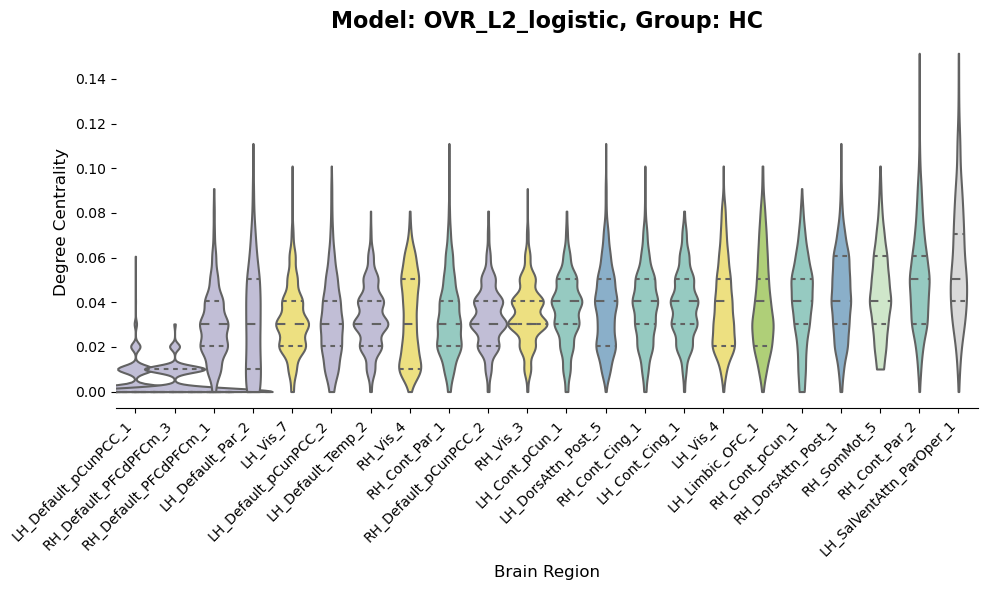

2025-04-21 16:15:32,717 - INFO - Saved DC violin plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/dc_violin_OVR_L2_logistic_Cannabis.svg



Plotting DC violin plots for model 'OVR_L2_logistic' and group 'Cannabis'...


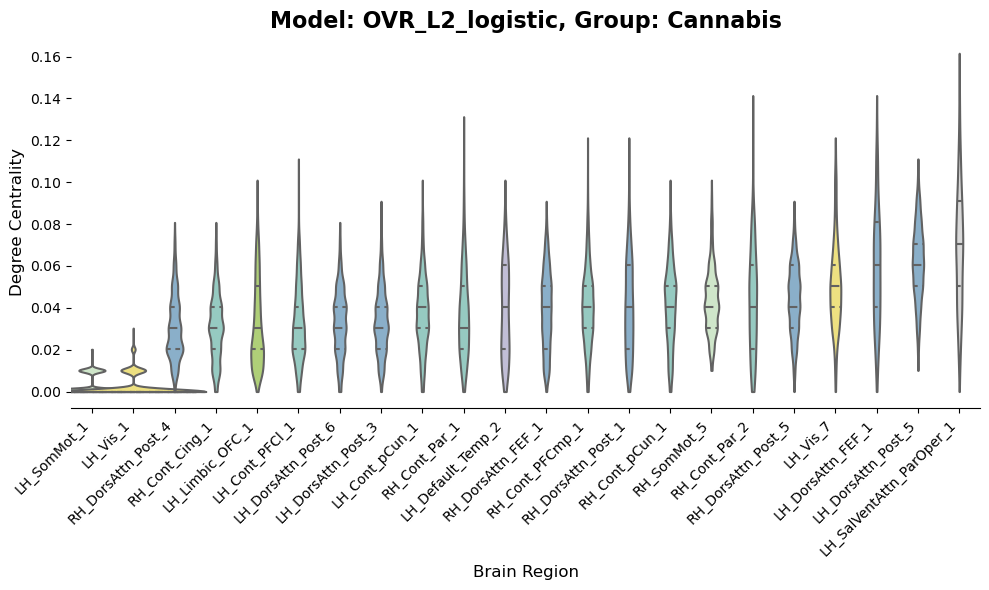

2025-04-21 16:15:33,040 - INFO - Saved DC violin plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/dc_violin_OVR_L2_logistic_Alcohol.svg



Plotting DC violin plots for model 'OVR_L2_logistic' and group 'Alcohol'...


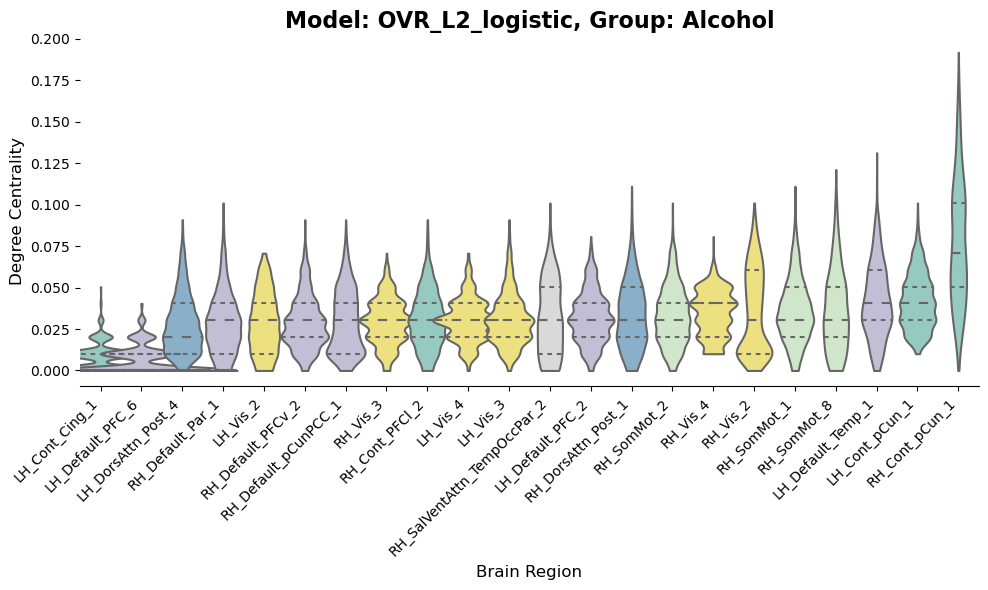

In [139]:
# --- Plot Violin Plots for Selected Model/Group (Matching Original Plot) ---
analysis_model_key = SELECTED_MODEL_KEY  # e.g., 'OVR_L2_logistic' or 'L2_logistic'

# Loop over all groups
for analysis_group_internal in all_graphs[analysis_model_key].keys():

    print(f"\nPlotting DC violin plots for model '{analysis_model_key}' and group '{analysis_group_internal}'...")

    # 1. Get run-level DC values for plotting ({parcel_name: [dc_run1, dc_run2, ...]})
    dc_values_for_plot = {name: [] for name in parcel_names}
    for _, graph_obj in all_graphs[analysis_model_key][analysis_group_internal]:
        try:
                # Get degree centrality values (from node attributes added during graph creation)
                node_dc_dict = nx.get_node_attributes(graph_obj.graph, 'degree_centrality')
                for parcel_name in parcel_names: # Iterate through all parcel names to ensure order
                    dc_values_for_plot[parcel_name].append(node_dc_dict.get(parcel_name, np.nan)) # Append NaN if not found

        except Exception as e:
                logging.error(f"  Error gathering run-level DC values for plotting: {e}", exc_info=True)
                # Append NaNs for all parcels for this run if error occurs
                for parcel_name in parcel_names:
                    dc_values_for_plot[parcel_name].append(np.nan)


    # 2. Get sorted selected parcel names for plotting x-axis
    # Get the DataFrame of average DC for the selected model/group
    avg_dc_df_select = avg_dc_dfs[analysis_model_key][analysis_group_internal]
    # Sort by mean DC ascending, handle NaNs by putting them last
    # Using .values makes argsort work even if index is not standard int range
    sorted_indices = np.argsort(avg_dc_df_select['Mean DC'].fillna(-np.inf).values) # Ascending, NaNs handled
    all_sorted_names = avg_dc_df_select.index[sorted_indices].tolist() # Get names in sorted order
    # Use SELECTED_IND_DC indices from config ON the sorted list of names
    # Ensure indices are within bounds of the sorted list
    selected_plot_indices = [i for i in SELECTED_IND_DC if 0 <= i < len(all_sorted_names)]
    selected_plot_names = [all_sorted_names[i] for i in selected_plot_indices]


    # 3. Create a mapping from parcel name to the RGBA color tuple (0-1 scale)
    # network_rgba_tuple should be available from the imports block where get_network_rgba was called
    parcel_to_color_tuple = {name: network_rgba_tuple[i] for i, name in enumerate(parcel_names)}

    # 4. Define plot title and figure path
    # model_filename_part = analysis_model_key.replace('OVR_', '').replace('OVO_', '')
    model_filename_part = analysis_model_key
    dc_plot_title = f'Model: {analysis_model_key}, Group: {analysis_group_internal}' # More descriptive title
    dc_figure_path = NETWORK_FIGURE_DIR / f"dc_violin_{model_filename_part}_{analysis_group_internal}.svg"

    # 5. Call the dedicated plotting function
    # Ensure dc_values_for_plot only contains lists corresponding to selected_plot_names
    # This might require filtering the dc_values_for_plot dict if the plotting function expects only selected ones
    # Or the plotting function iterates over selected_parcel_names and uses the dict.
    # The plot_degree_centrality_violins function iterates over selected_parcel_names and uses the dict, so dc_values_for_plot should contain all parcels.
    plot_degree_centrality_violins(
        dc_values_dict=dc_values_for_plot,         # Pass the dict with values for all parcels
        selected_parcel_names=selected_plot_names, # Pass the list of names to plot (defines x-axis)
        parcel_name_to_color=parcel_to_color_tuple,# Pass the mapping for all parcels
        title=dc_plot_title,                       # Plot title
        figure_path=dc_figure_path,                # Path to save,
        figsize=(10, 6),                            # Figure size
    )

2025-04-21 16:18:15,254 - INFO - Successfully loaded data from /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/degree_centrality/threeclass/threeclass_dc_summary.pkl
2025-04-21 16:18:15,331 - INFO - Saved radar plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_dc_radar_comparison.svg



Generating Network Radar Plot

Generating radar plot...

Finished Network Radar Plot



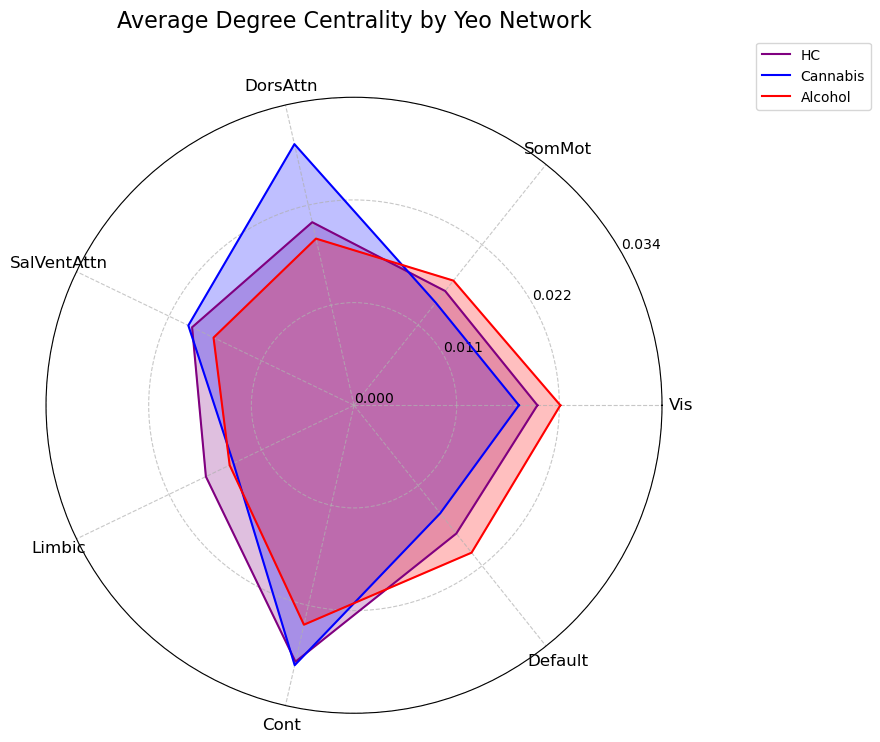

In [147]:
# === 4. Generate Network Radar Plot ===
# This cell aggregates Degree Centrality by Yeo network for each group
# and generates a radar plot comparing the groups.

print("\n" + "="*40)
print("Generating Network Radar Plot")
print("="*40 + "\n")

# --- 1. Prepare Input Data for Plotting ---
# Extract the relevant DC scores for each group based on ROI_SELECTION_MODEL_KEY
# We want a dictionary like: {'HC': {parcel: dc, ...}, 'Cannabis': {parcel: dc, ...}, ...}
dc_data_all_models = load_pickle(dc_pickle_path)
dc_data_for_plot = {key: value[SELECTED_MODEL_KEY] for key, value in dc_data_all_models.items()}
plot_successful = True

# --- 2. Define Network Order ---
# IMPORTANT: Define the order you want the networks to appear on the axes
# Should match the networks present in your 'network_inds' keys. Check them!
# Example order based on Yeo 7 Network typical representation:
network_order = [
    'Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default'
]
# Verify all networks in network_order exist in network_inds
if not all(net in network_inds for net in network_order):
     logging.warning(f"One or more networks in network_order ({network_order}) not found in network_inds ({list(network_inds.keys())}). Plot axes might be incorrect.")


# --- 3. Define Colors ---
group_colors = {
    'HC': 'purple', # Or use hex codes, e.g., '#9932CC'
    'Alcohol': 'red', # Or '#DC143C'
    'Cannabis': 'blue' # Or '#1E90FF'
}

# --- 4. Generate Plot (if data is ready) ---
if plot_successful:
    print("Generating radar plot...")
    radar_fig_path = FIGURE_DIR / "network_dc_radar_comparison.svg"
    radar_ax = plot_network_radar(
        dc_data_per_group=dc_data_for_plot,
        parcel_names=parcel_names,
        network_indices=network_inds,
        network_order=network_order,
        group_colors=group_colors,
        title="Average Degree Centrality by Yeo Network",
        figure_path=radar_fig_path
    )
    # plot_network_radar automatically calls plt.show() if ax is None
else:
    print("Skipping radar plot generation due to missing data.")


print("\n" + "="*40)
print("Finished Network Radar Plot")
print("="*40 + "\n")

### NETWORK EFFICIENCY

In [55]:
# === 4. Calculate and Analyze Efficiency Measures ===
# This cell calculates Global and Local Efficiency for each run-level graph,
# performs statistical comparisons between groups (if labels are available),
# saves the results, and plots violin plots.

print("\n" + "="*40)
print("Starting Efficiency Measures Calculation")
print("="*40 + "\n")

# --- Calculate Efficiency ---
print("Calculating Global and Local Efficiency per run...")
if not all_graphs:
    logging.warning("'all_graphs' dictionary is empty. Skipping efficiency calculation.")
    efficiency_results = {} # Initialize as empty
else:
    # Call the function from src/network_analysis
    # Pass the labels array to enable group comparisons within the function
    efficiency_results = calculate_efficiency(
        all_graphs=all_graphs,
        labels_per_run=labels # Pass the labels array
    )

# --- Save Efficiency Results ---
print("\nSaving efficiency results...")
efficiency_output_dir = ANALYSIS_RESULTS_DIR / "efficiency_analysis" # Dedicated subdir for efficiency results
efficiency_output_dir.mkdir(parents=True, exist_ok=True) # Ensure directory exists

# Save the full dictionary of DataFrames
efficiency_pickle_path = efficiency_output_dir / "all_models_groups_efficiency.pkl"
pickle_file(efficiency_results, efficiency_pickle_path)
print(f"Saved efficiency results pickle to {efficiency_pickle_path}")

# Optionally save individual DataFrames to CSV if needed
# Example: loop through results and save each DataFrame
# for model_key, group_data in efficiency_results.items():
#      for group_key, eff_df in group_data.items():
#           if not eff_df.empty:
#                csv_path = efficiency_output_dir / f"{model_key.replace('OVR_', '').replace('OVO_', '')}_{group_key}_efficiency.csv"
#                try: eff_df.to_csv(csv_path, index=False); print(f"  Saved {csv_path}")
#                except Exception as e: logging.error(f"  Failed to save {csv_path}: {e}")


Starting Efficiency Measures Calculation

Calculating Global and Local Efficiency per run...
    Mann-Whitney U (HC - Global Eff): p = 0.4994
    Mann-Whitney U (HC - Local Eff): p = 0.0000
    Mann-Whitney U (Cannabis - Global Eff): p = 0.3212
    Mann-Whitney U (Cannabis - Local Eff): p = 0.0009
    Mann-Whitney U (Alcohol - Global Eff): p = 0.0003
    Mann-Whitney U (Alcohol - Local Eff): p = 0.0119
    Mann-Whitney U (HC - Global Eff): p = 0.9259
    Mann-Whitney U (HC - Local Eff): p = 0.0003
    Mann-Whitney U (Cannabis - Global Eff): p = 0.6222
    Mann-Whitney U (Cannabis - Local Eff): p = 0.1015
    Mann-Whitney U (Alcohol - Global Eff): p = 0.0142
    Mann-Whitney U (Alcohol - Local Eff): p = 0.0037
    Mann-Whitney U (HC - Global Eff): p = 0.7450
    Mann-Whitney U (HC - Local Eff): p = 0.2659
    Mann-Whitney U (Cannabis - Global Eff): p = 0.1097
    Mann-Whitney U (Cannabis - Local Eff): p = 0.0000
    Mann-Whitney U (Alcohol - Global Eff): p = 0.0124
    Mann-Whitney U (

2025-04-21 11:04:20,207 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/efficiency_analysis/all_models_groups_efficiency.pkl


    Mann-Whitney U (Alcohol - Global Eff): p = 0.0236
    Mann-Whitney U (Alcohol - Local Eff): p = 0.1293

Saving efficiency results...
Saved efficiency results pickle to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/efficiency_analysis/all_models_groups_efficiency.pkl


/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
2025-04-21 11:13:49,527 - INFO - Saved efficiency plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/efficiency_violin_L2_logistic_HC.svg



Plotting Efficiency Violins for model 'OVR_L2_logistic'...


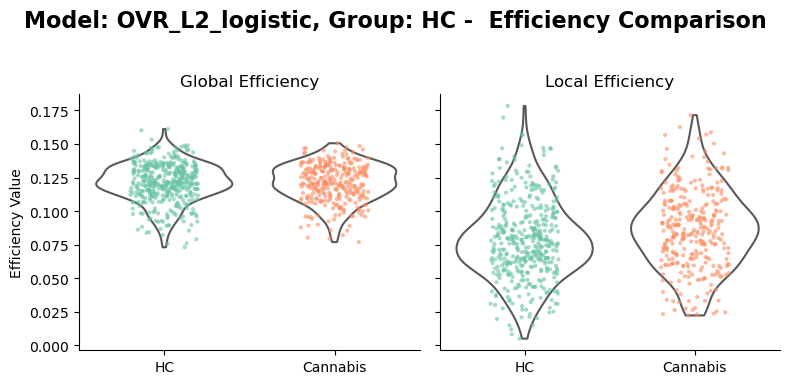

/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
2025-04-21 11:13:49,762 - INFO - Saved efficiency plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/efficiency_violin_L2_logistic_Cannabis.svg


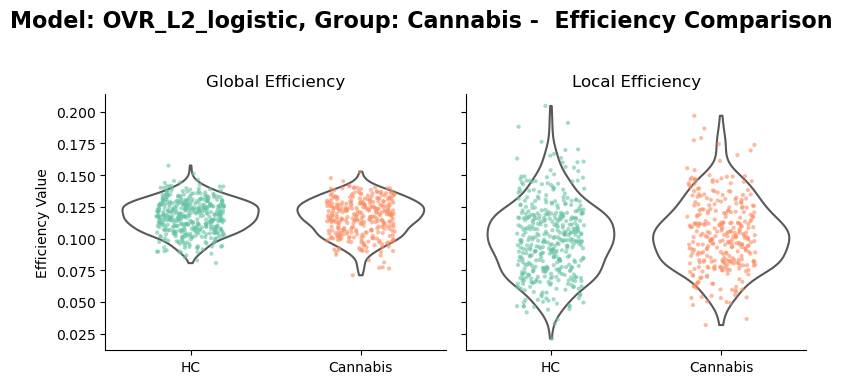

/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
/Users/kulkarnik/LocalProjects/multiclassifier_repo/src/plotting_utils.py:221: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  # Clear the right half of the violins manually
2025-04-21 11:13:49,976 - INFO - Saved efficiency plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/efficiency_violin_L2_logistic_Alcohol.svg


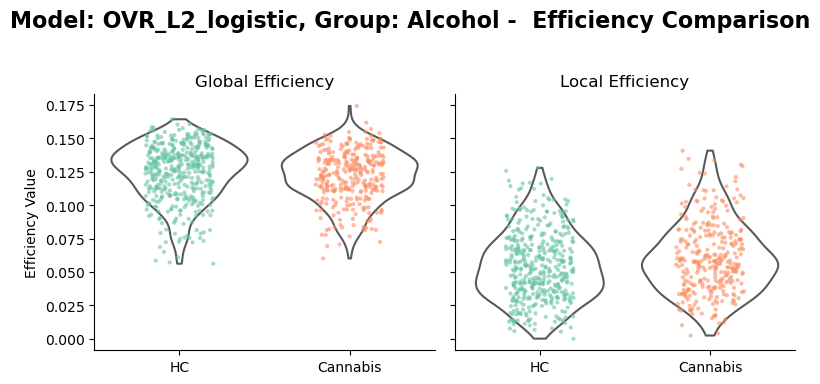


Finished Efficiency Measures Calculation



In [66]:
# --- Plot Efficiency Comparisons for Selected Model ---
analysis_model_key = SELECTED_MODEL_KEY # From config

if analysis_model_key in efficiency_results:
    print(f"\nPlotting Efficiency Violins for model '{analysis_model_key}'...")
    # Iterate through the groups available for this model
    for group_key, eff_df in efficiency_results[analysis_model_key].items():
         # Check if this group's DataFrame has data and labels suitable for plotting (2 unique labels)
         if not eff_df.empty and 'label' in eff_df.columns and eff_df['label'].dropna().nunique() == 2:
             # Get group labels for plotting based on the unique label values (0 and 1 assumed)
             # Map the numeric labels to meaningful strings using config MULTICLASS_LABELS
             unique_labels_found = sorted(eff_df['label'].dropna().unique())
             if unique_labels_found == [0, 1] and 'MULTICLASS_LABELS' in locals() and len(MULTICLASS_LABELS) >= 2:
                 group_labels_for_plot = [MULTICLASS_LABELS[0], MULTICLASS_LABELS[1]] # Map 0 to HC, 1 to Cannabis or Alcohol depending on context
                 # Note: This mapping might need careful consideration depending on how 'labels' was generated.
                 # If 'labels' is 0 for control and 1 for user *across both groups*, this mapping is fine.
                 # If 'labels' encodes 3 classes (0, 1, 2), the `calculate_efficiency` function would have skipped comparison.
             else:
                 # Fallback to generic names if label values are not 0,1 or MULTICLASS_LABELS not suitable
                 group_labels_for_plot = [f"Label {int(ul)}" for ul in unique_labels_found]
                 logging.warning(f"  Plotting with generic group labels for {group_key}: {group_labels_for_plot}")

             plot_efficiency_violins(
                 efficiency_df=eff_df,
                 group_labels=group_labels_for_plot, # Pass the mapped group labels
                 title_prefix=f"Model: {analysis_model_key}, Group: {group_key} - ", # Include model/group in title
                 figure_dir=NETWORK_FIGURE_DIR, # Save figures here
                 model_name=analysis_model_key, # Pass names for filename
                 group_name=group_key, # Pass names for filename,
                 figsize=(8, 4), # Figure size
             )
         elif not eff_df.empty:
             logging.warning(f"  Skipping efficiency plot for model '{analysis_model_key}', group '{group_key}': Need exactly 2 unique non-NaN labels for comparison plot.")
         else:
             logging.warning(f"  Skipping efficiency plot for model '{analysis_model_key}', group '{group_key}': No data in DataFrame.")
else:
    print(f"Skipping efficiency plots: No efficiency results found for selected model '{analysis_model_key}'. Ensure 'calculate_efficiency' ran successfully.")


print("\n" + "="*40)
print("Finished Efficiency Measures Calculation")
print("="*40 + "\n")

### COMMUNITY DETECTION

In [67]:
# === 5. Community Detection on Average WFC ===
# This cell calculates the average WFC for each model/group, thresholds it,
# creates a graph, and performs community detection (e.g., Girvan-Newman)
# storing the results, including the graph object and communities found.

print("\n" + "="*40)
print("Starting Community Detection on Average WFC")
print("="*40 + "\n")

if not run_wfc:
     logging.warning("'run_wfc' dictionary is empty. Skipping community detection.")
     community_results = {} # Initialize as empty

# --- Run Community Detection ---
print(f"Detecting communities using threshold percentile: {COMM_THRESHOLD_PERC}% and levels: {YEO_NETWORKS}...")
community_results = detect_communities_on_average(
    run_wfc_data=run_wfc,             # Run-level WFC vectors
    parcel_names=parcel_names,        # List of parcel names
    network_indices=network_inds,     # Network assignments for parcels
    threshold_percentile=COMM_THRESHOLD_PERC, # Threshold from config
    levels=YEO_NETWORKS               # Girvan-Newman levels from config
)

# --- Verification and Summary ---
if not community_results:
    logging.warning("Community detection function returned no results. Check logs.")
else:
    print("\nCommunity detection summary:")
    successful_detections = 0
    for analysis_key, result_data in community_results.items():
        if 'error' in result_data:
             print(f"  {analysis_key}: FAILED during detection ({result_data['error']})")
        elif 'communities' in result_data:
             num_comms = len(result_data['communities'])
             print(f"  {analysis_key}: Found {num_comms} communities.")
             if num_comms > 0:
                 successful_detections += 1
        else:
             print(f"  {analysis_key}: No communities found or result structure unexpected.")

    if successful_detections > 0:
        print(f"\nSuccessfully detected communities for {successful_detections} model/group combinations.")
        # Example check on first successful result
        first_success_key = None
        for key, data in community_results.items():
            if 'communities' in data:
                first_success_key = key
                break
        if first_success_key:
            try:
                print(f"\nExample communities from '{first_success_key}':")
                # Print first few communities for brevity
                for i, comm_set in enumerate(community_results[first_success_key]['communities'][:3]):
                    print(f"  Community {i+1}: {list(comm_set)[:5]}...") # Print first 5 members
                if len(community_results[first_success_key]['communities']) > 3: print("  ...")
                # Check graph object
                print(f"  Graph object type: {type(community_results[first_success_key]['graphobj'])}")
            except Exception as e:
                print(f"\nCould not display example community info: {e}")
    else:
        print("\nNo communities were successfully detected for any model/group.")


print("\n" + "="*40)
print("Finished Community Detection")
print("="*40 + "\n")

2025-04-21 11:15:48,629 - INFO - Detecting communities for model: OVR_L1_logistic
2025-04-21 11:15:48,629 - INFO -   Processing group: HC -> Analysis Key: OVR_L1_logistic_HC
2025-04-21 11:15:48,635 - INFO -     Applied 98% threshold (value >= 14.5667) to average positive WFC.
2025-04-21 11:15:48,638 - INFO -     Running Girvan-Newman community detection (levels=7)...
2025-04-21 11:15:48,679 - INFO -     Detected 32 communities for OVR_L1_logistic_HC at level 7.
2025-04-21 11:15:48,680 - INFO -   Processing group: Cannabis -> Analysis Key: OVR_L1_logistic_Cannabis
2025-04-21 11:15:48,686 - INFO -     Applied 98% threshold (value >= 12.3056) to average positive WFC.
2025-04-21 11:15:48,688 - INFO -     Running Girvan-Newman community detection (levels=7)...
2025-04-21 11:15:48,742 - INFO -     Detected 42 communities for OVR_L1_logistic_Cannabis at level 7.
2025-04-21 11:15:48,743 - INFO -   Processing group: Alcohol -> Analysis Key: OVR_L1_logistic_Alcohol
2025-04-21 11:15:48,749 - INFO


Starting Community Detection on Average WFC

Detecting communities using threshold percentile: 98% and levels: 7...


2025-04-21 11:15:48,897 - INFO -     Detected 32 communities for OVR_L2_logistic_HC at level 7.
2025-04-21 11:15:48,898 - INFO -   Processing group: Cannabis -> Analysis Key: OVR_L2_logistic_Cannabis
2025-04-21 11:15:48,905 - INFO -     Applied 98% threshold (value >= 77.9218) to average positive WFC.
2025-04-21 11:15:48,907 - INFO -     Running Girvan-Newman community detection (levels=7)...
2025-04-21 11:15:48,974 - INFO -     Detected 36 communities for OVR_L2_logistic_Cannabis at level 7.
2025-04-21 11:15:48,974 - INFO -   Processing group: Alcohol -> Analysis Key: OVR_L2_logistic_Alcohol
2025-04-21 11:15:48,982 - INFO -     Applied 98% threshold (value >= 55.1529) to average positive WFC.
2025-04-21 11:15:48,984 - INFO -     Running Girvan-Newman community detection (levels=7)...
2025-04-21 11:15:49,065 - INFO -     Detected 31 communities for OVR_L2_logistic_Alcohol at level 7.
2025-04-21 11:15:49,065 - INFO - Detecting communities for model: OVR_L1_LinearSVC
2025-04-21 11:15:49,


Community detection summary:
  OVR_L1_logistic_HC: Found 32 communities.
  OVR_L1_logistic_Cannabis: Found 42 communities.
  OVR_L1_logistic_Alcohol: Found 31 communities.
  OVR_L2_logistic_HC: Found 32 communities.
  OVR_L2_logistic_Cannabis: Found 36 communities.
  OVR_L2_logistic_Alcohol: Found 31 communities.
  OVR_L1_LinearSVC_HC: Found 28 communities.
  OVR_L1_LinearSVC_Cannabis: Found 35 communities.
  OVR_L1_LinearSVC_Alcohol: Found 31 communities.
  OVR_L2_LinearSVC_HC: Found 30 communities.
  OVR_L2_LinearSVC_Cannabis: Found 36 communities.
  OVR_L2_LinearSVC_Alcohol: Found 33 communities.

Successfully detected communities for 12 model/group combinations.

Example communities from 'OVR_L1_logistic_HC':
  Community 1: ['LH_Vis_1']...
  Community 2: ['LH_Vis_2']...
  Community 3: ['LH_Vis_5', 'LH_Vis_3', 'LH_Vis_4', 'RH_Vis_5', 'RH_Vis_7']...
  ...
  Graph object type: <class 'network_utils.GraphFromConnectivity'>

Finished Community Detection



In [84]:
analysis_group_internal

'Alcohol'


Starting Community Analysis and Plotting


Calculating mean DC per community...

Community Analysis Summary (Sorted by Mean DC):


,Community ID,N Regions,Mean DC
0,2,19,0.028818
1,3,15,0.026925
2,14,4,0.021539
3,7,8,0.020634
4,8,3,0.020133
5,18,9,0.018968
6,13,3,0.018332
7,15,1,0.018157
8,12,5,0.017980
9,19,6,0.017703


2025-04-21 11:47:53,059 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_communities_df.pkl
2025-04-21 11:47:53,060 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_community_details.pkl


Saved community DC analysis to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_communities_dc.csv and /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_communities_df.pkl
Saved detailed community results object to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_community_details.pkl

Plotting Community-Sorted Average WFC Heatmap...
Saved community heatmap to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_HC_community_sorted_heatmap.svg


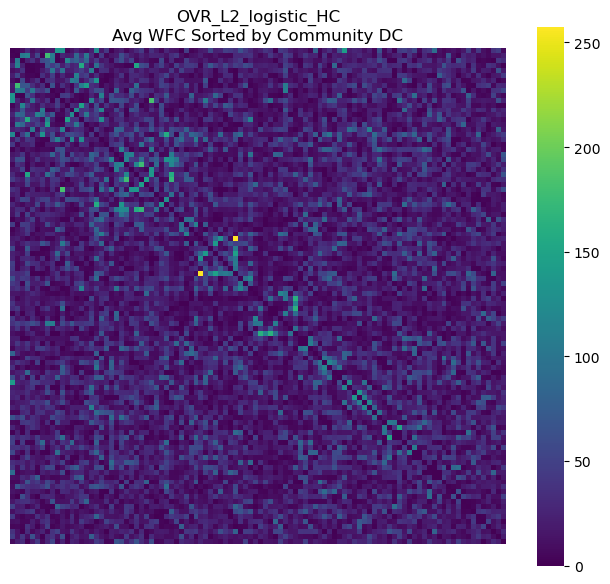


Plotting Top Community Connectomes...
  Loaded Schaefer atlas coordinates (Shape: (100, 3))
Saved top communities connectome plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_HC_top_communities_connectomes.svg


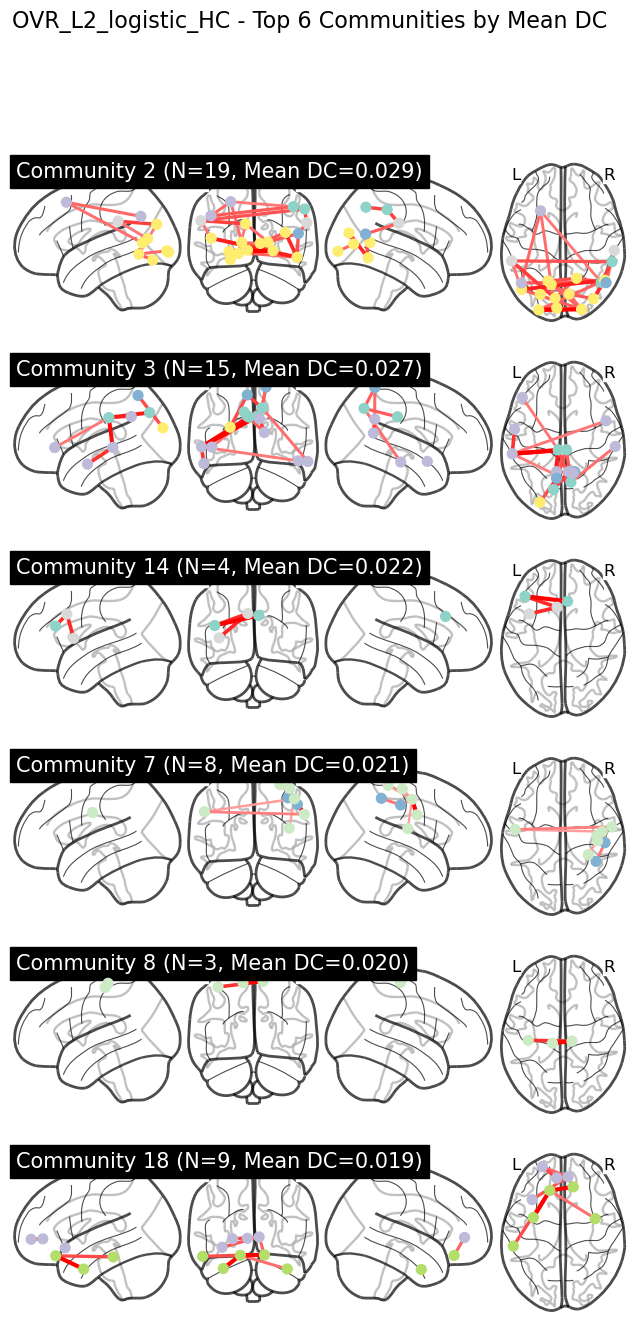


Calculating mean DC per community...

Community Analysis Summary (Sorted by Mean DC):


,Community ID,N Regions,Mean DC
0,9,10,0.038979
1,3,8,0.026178
2,18,11,0.025787
3,14,11,0.025625
4,2,6,0.020361
5,17,9,0.020220
6,7,11,0.019370
7,23,1,0.018267
8,15,3,0.017862
9,20,1,0.014288


2025-04-21 11:47:58,164 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_communities_df.pkl
2025-04-21 11:47:58,165 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_community_details.pkl


Saved community DC analysis to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_communities_dc.csv and /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_communities_df.pkl
Saved detailed community results object to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_community_details.pkl

Plotting Community-Sorted Average WFC Heatmap...
Saved community heatmap to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_Cannabis_community_sorted_heatmap.svg


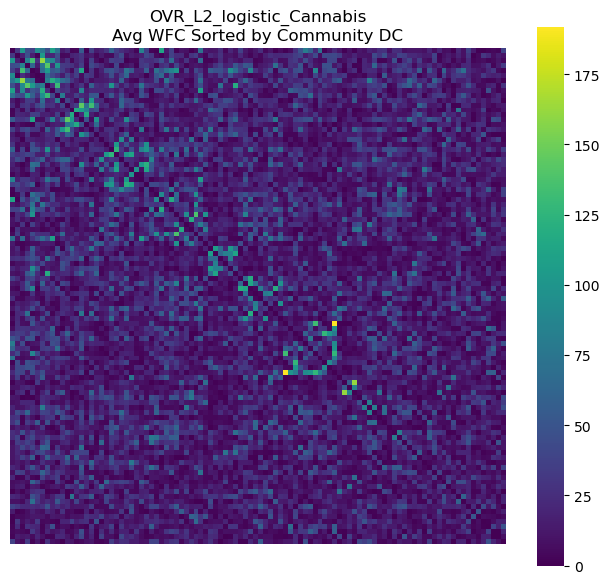


Plotting Top Community Connectomes...
  Loaded Schaefer atlas coordinates (Shape: (100, 3))
Saved top communities connectome plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_Cannabis_top_communities_connectomes.svg


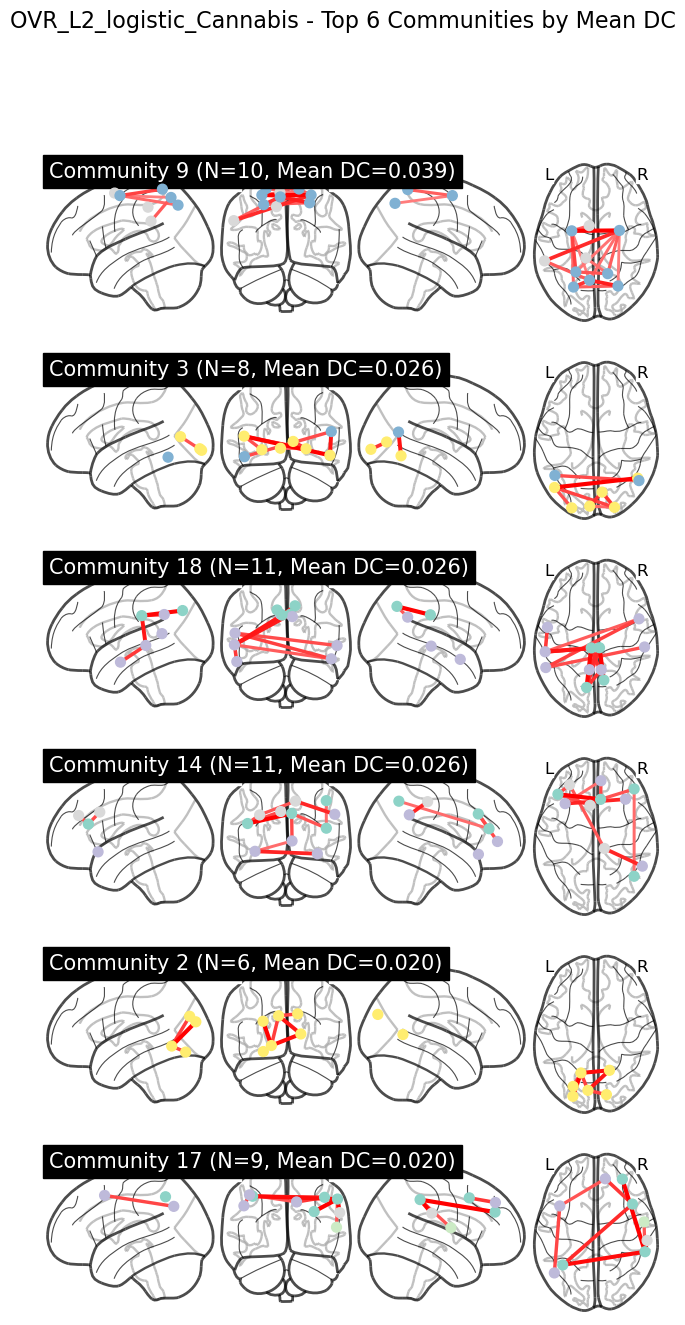


Calculating mean DC per community...

Community Analysis Summary (Sorted by Mean DC):


,Community ID,N Regions,Mean DC
0,1,19,0.025667
1,8,8,0.024045
2,6,10,0.023654
3,19,9,0.021622
4,2,8,0.021285
5,3,9,0.020979
6,17,8,0.019819
7,30,1,0.019373
8,24,1,0.018668
9,23,1,0.017894


2025-04-21 11:48:03,171 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_communities_df.pkl
2025-04-21 11:48:03,172 - INFO - Successfully saved data to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_community_details.pkl


Saved community DC analysis to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_communities_dc.csv and /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_communities_df.pkl
Saved detailed community results object to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_community_details.pkl

Plotting Community-Sorted Average WFC Heatmap...
Saved community heatmap to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_Alcohol_community_sorted_heatmap.svg


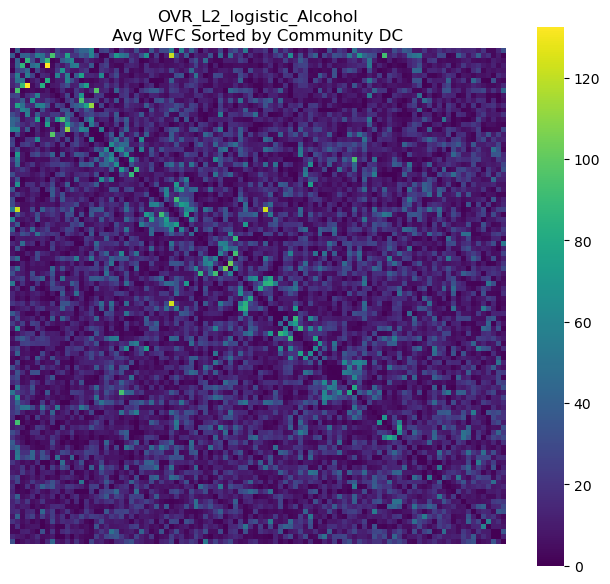


Plotting Top Community Connectomes...
  Loaded Schaefer atlas coordinates (Shape: (100, 3))
Saved top communities connectome plot to /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/figures/network_analysis/OVR_L2_logistic_Alcohol_top_communities_connectomes.svg


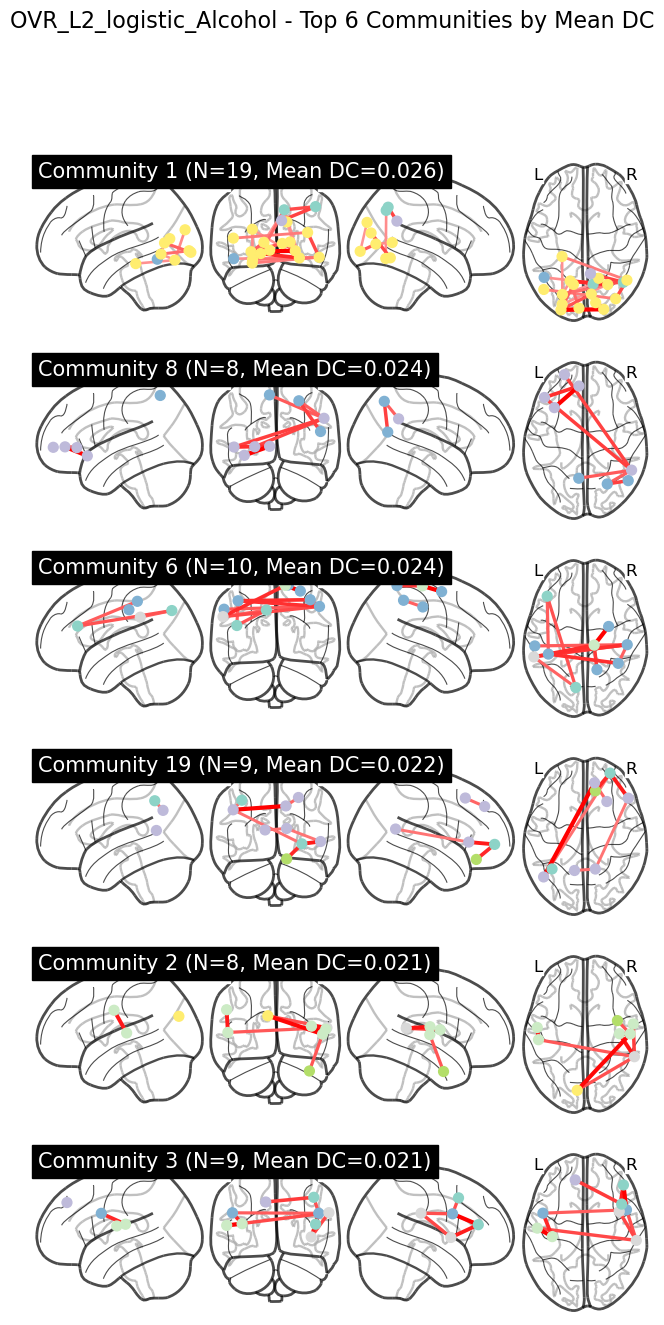


Finished Community Analysis



In [101]:
# === 6. Analyze and Plot Communities for Selected Model/Group ===
# This cell takes the community detection results, combines them with
# average DC scores, sorts communities, and generates plots (heatmap, connectomes)
# for a specific model/group combination selected in the config.

print("\n" + "="*40)
print("Starting Community Analysis and Plotting")
print("="*40 + "\n")

# --- Select Model and Group for Detailed Analysis ---
# Use SELECTED_MODEL_KEY from config.
# Find the corresponding internal group key (e.g., 'HC') for this model.
# Assume the analysis focuses on the first group associated with the selected model in avg_dc_dfs.
analysis_model_key = SELECTED_MODEL_KEY
for analysis_group_internal in avg_dc_dfs[analysis_model_key].keys():

    # --- Check if Community Detection Data Exists ---
    analysis_key = f"{analysis_model_key}_{analysis_group_internal}"
    if analysis_key not in community_results:
        raise ValueError(f"No community results found for selected key '{analysis_key}'. Ensure community detection ran successfully.")
    if 'error' in community_results[analysis_key]:
        raise RuntimeError(f"Community detection failed for '{analysis_key}': {community_results[analysis_key]['error']}")
    if 'communities' not in community_results[analysis_key] or not community_results[analysis_key]['communities']:
        raise ValueError(f"No community results found for selected key '{analysis_key}'. Ensure community detection ran successfully.")
    # --- Prepare Community DataFrame with Mean DC ---
    print("\nCalculating mean DC per community...")
    result_data = community_results[analysis_key]
    communities = result_data['communities']
    avg_graph_obj = result_data['graphobj']
    avg_wfc_vector = result_data['avg_wfc_vector'] # Avg WFC for heatmap later
    n_communities = len(communities)
    avg_dc_df_selected = avg_dc_dfs[analysis_model_key][analysis_group_internal]

    community_analysis = []
    for i, comm_set in enumerate(communities):
        comm_names = sorted(list(comm_set)) # Sort names within community for consistency
        # Get DC values for parcels in this community, handling potential missing parcels/NaNs
        comm_dcs = avg_dc_df_selected.loc[avg_dc_df_selected.index.intersection(comm_names), 'Mean DC'].dropna()
        mean_comm_dc = comm_dcs.mean() if not comm_dcs.empty else np.nan
        comm_indices = parcel_names_to_indices(comm_set, parcel_names) # Get indices
        community_analysis.append({
            'Community ID': i + 1, 'N Regions': len(comm_set), 'Mean DC': mean_comm_dc,
            'Parcel Names': comm_names, 'Parcel Indices': comm_indices
        })
    # Create DataFrame and sort by Mean DC (descending), NaNs last
    comm_df = pd.DataFrame(community_analysis).sort_values(by='Mean DC', ascending=False, na_position='last').reset_index(drop=True)
    print("\nCommunity Analysis Summary (Sorted by Mean DC):")
    display(comm_df[['Community ID', 'N Regions', 'Mean DC']].head(10)) # Display top 10

    # Save community analysis DataFrame
    comm_df_path = NETWORK_ANALYSIS_DIR / f"{analysis_key}_communities_dc.csv"
    comm_df_pickle_path = NETWORK_ANALYSIS_DIR / f"{analysis_key}_communities_df.pkl"
    try:
        comm_df.to_csv(comm_df_path, index=False)
        pickle_file(comm_df, comm_df_pickle_path) # Save pickle as well
        print(f"Saved community DC analysis to {comm_df_path} and {comm_df_pickle_path}")
    except Exception as e:
        print(f"Failed to save community analysis files: {e}")

    # Save full community results object (includes graph, vectors, communities)
    comm_pickle_path = NETWORK_ANALYSIS_DIR / f"{analysis_key}_community_details.pkl"
    pickle_file(result_data, comm_pickle_path) # Overwrites previous if exists
    print(f"Saved detailed community results object to {comm_pickle_path}")

    # --- Plotting ---
    print("\nPlotting Community-Sorted Average WFC Heatmap...")
    try:
        # Combine all parcel indices from communities in the new sorted order
        ordered_reorg_comm_indices = np.concatenate(comm_df['Parcel Indices'])
        # Convert the average WFC vector back to a matrix for plotting
        avg_wfc_matrix = vector_to_symmetric_matrix(avg_wfc_vector)

        fig_heatmap_comm, ax_heatmap_comm = plt.subplots(figsize=(8, 7)) # Adjusted size
        plot_connectivity_heatmap(
            matrix=avg_wfc_matrix,
            reordered_indices=ordered_reorg_comm_indices, # Pass the indices in the desired order
            title=f'{analysis_key}\nAvg WFC Sorted by Community DC',
            cmap='viridis', ax=ax_heatmap_comm, cbar=True # Add colorbar
        )
        heatmap_path = NETWORK_FIGURE_DIR / f"{analysis_key}_community_sorted_heatmap.svg"
        fig_heatmap_comm.savefig(str(heatmap_path), bbox_inches='tight') # Save the figure
        print(f"Saved community heatmap to {heatmap_path}")
        plt.show() # Show the plot inline
    except Exception as e:
        logging.error(f"Failed to plot community heatmap: {e}", exc_info=True)

    # --- Plot Top Community Connectomes ---
    print("\nPlotting Top Community Connectomes...")
    try:
        # Get coordinates (needs atlas loaded - ensure nilearn is imported)
        # Make sure atlas loading happens only once if possible (e.g., in config or setup cell)
        try:
            schaefer_atlas = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=N_ROIS, yeo_networks=YEO_NETWORKS, resolution_mm=RESOLUTION_MM)
            schaefer_coords = nilearn.plotting.find_parcellation_cut_coords(labels_img=schaefer_atlas["maps"])
            print(f"  Loaded Schaefer atlas coordinates (Shape: {schaefer_coords.shape})")
        except Exception as atlas_e:
            raise RuntimeError(f"Failed to load Schaefer atlas coordinates: {atlas_e}")

        # Determine how many top communities to plot
        n_top_comms_to_plot = min(6, n_communities) # Plot top 6 or fewer if less exist
        if n_top_comms_to_plot > 0:
            fig_conns, axes_conns = plt.subplots(figsize=(8, 2.5 * n_top_comms_to_plot), nrows=n_top_comms_to_plot, ncols=1, squeeze=False)
            axes_conns = axes_conns.flatten() # Ensure it's always iterable

            # Get the average adjacency matrix for plotting connectomes
            # Use the thresholded average graph object created during community detection
            avg_adj_matrix = nx.to_numpy_array(avg_graph_obj.graph, nodelist=parcel_names)


            for i in range(n_top_comms_to_plot):
                row = comm_df.iloc[i] # Get data for the i-th community (sorted by DC)
                comm_indices = row['Parcel Indices']
                comm_coords = schaefer_coords[comm_indices] # Get coords for these nodes
                comm_colors_rgba = network_rgba_tuple[comm_indices] # Get colors for these nodes

                # Extract the sub-matrix for within-community connections
                comm_adj = avg_adj_matrix[np.ix_(comm_indices, comm_indices)]

                # Call the plotting function from src/plotting_utils
                plot_community_connectome(
                    adjacency_matrix=comm_adj,
                    node_coords=comm_coords,
                    node_colors=comm_colors_rgba, # Pass RGBA tuples
                    title=f'Community {row["Community ID"]} (N={row["N Regions"]}, Mean DC={row["Mean DC"]:.3f})',
                    ax=axes_conns[i],
                    node_size=50, # Adjust size as needed
                    # Optional: Pass black_bg=True if desired
                    # figure_path=NETWORK_FIGURE_DIR / f"{analysis_key}_community_{row['Community ID']}_connectome.png" # Save individual plots if needed
                )
            fig_conns.suptitle(f'{analysis_key} - Top {n_top_comms_to_plot} Communities by Mean DC', fontsize=16)
            # plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout

            # Save the combined figure
            conn_fig_path = NETWORK_FIGURE_DIR / f"{analysis_key}_top_communities_connectomes.svg"
            fig_conns.savefig(str(conn_fig_path), bbox_inches='tight') # Ensure path is string
            print(f"Saved top communities connectome plot to {conn_fig_path}")
            plt.show()
        else:
            print("No communities found to plot.")

    except Exception as e:
        logging.error(f"Failed during connectome plotting: {e}", exc_info=True)


# Final message for this analysis block
print("\n" + "="*40)
print("Finished Community Analysis")
print("="*40 + "\n")

In [110]:
# === 7. Display Members and DC Scores for a Selected Community ===
# This cell allows inspection of the parcel names and their average Degree Centrality
# scores within a specific community, identified by its rank (sorted by Mean DC).

print("\n" + "="*40)
print("Displaying Details for a Selected Community")
print("="*40 + "\n")

# --- Configuration for this Cell ---
# Select the community number to display (1 = highest Mean DC, 2 = second highest, etc.)
COMMUNITY_RANK_TO_DISPLAY = 1 # Change this number to view different communities

# --- Load comm_df from the saved pickle file ---
analysis_model_key = SELECTED_MODEL_KEY
analysis_group_internal = 'Cannabis'
analysis_key = f"{analysis_model_key}_{analysis_group_internal}"
comm_df_path = NETWORK_ANALYSIS_DIR / f"{analysis_model_key}_{analysis_group_internal}_communities_df.pkl"
comm_df = pd.read_pickle(comm_df_path) # Load the DataFrame from the pickle file

if comm_df.empty:
    print("Community DataFrame ('comm_df') is empty. Cannot display community members.")
elif not (1 <= COMMUNITY_RANK_TO_DISPLAY <= len(comm_df)):
    print(f"Invalid COMMUNITY_RANK_TO_DISPLAY ({COMMUNITY_RANK_TO_DISPLAY}). Must be between 1 and {len(comm_df)}.")
else:
    # --- Get Data for Selected Community ---
    # comm_df is already sorted by Mean DC descending
    selected_community_row = comm_df.iloc[COMMUNITY_RANK_TO_DISPLAY - 1]
    selected_community_id = selected_community_row['Community ID']
    selected_community_parcels = selected_community_row['Parcel Names'] # List of parcel names

    print(f"--- Details for Community Rank #{COMMUNITY_RANK_TO_DISPLAY} (ID: {selected_community_id}) ---")
    print(f"   Model: {SELECTED_MODEL_KEY}")
    print(f"   Group: {analysis_group_internal}") # Display the internal group key used
    print(f"   Number of Regions: {selected_community_row['N Regions']}")
    print(f"   Mean DC for Community: {selected_community_row['Mean DC']:.4f}\n")

    # --- Retrieve and Print Parcel DCs ---
    # Get the average DC scores for the selected model and group
    dc_scores_for_group = avg_dc_dfs[SELECTED_MODEL_KEY][analysis_group_internal]['Mean DC']

    print("   Parcel Name                  \tAverage DC")
    print("   -----------------------------\t----------")
    # Sort parcels alphabetically within the community for consistent display
    for parcel_name in sorted(selected_community_parcels):
        dc_score = dc_scores_for_group.get(parcel_name, np.nan) # Get score, default NaN
        # Use f-string formatting for alignment
        print(f"   {parcel_name:<30}\t{dc_score:.4f}")

print("\n" + "="*40)
print("Finished Displaying Selected Community Details")
print("="*40 + "\n")


Displaying Details for a Selected Community

--- Details for Community Rank #1 (ID: 9) ---
   Model: OVR_L2_logistic
   Group: Cannabis
   Number of Regions: 10
   Mean DC for Community: 0.0390

   Parcel Name                  	Average DC
   -----------------------------	----------
   LH_DorsAttn_FEF_1             	0.0585
   LH_DorsAttn_Post_3            	0.0337
   LH_DorsAttn_Post_5            	0.0615
   LH_DorsAttn_Post_6            	0.0329
   LH_SalVentAttn_Med_2          	0.0145
   LH_SalVentAttn_Med_3          	0.0066
   LH_SalVentAttn_ParOper_1      	0.0683
   RH_DorsAttn_FEF_1             	0.0391
   RH_DorsAttn_Post_4            	0.0305
   RH_DorsAttn_Post_5            	0.0441

Finished Displaying Selected Community Details



In [111]:
# === 8. Save Community Parcel Lists to CSV ===
# This cell iterates through the communities identified for the selected model/group
# (as stored in comm_df) and saves the list of parcel names for each community
# into a separate CSV file.

print("\n" + "="*40)
print("Saving Community Parcel Lists to CSV")
print("="*40 + "\n")


analysis_model_key = SELECTED_MODEL_KEY
for analysis_group_internal in avg_dc_dfs[analysis_model_key].keys():
    # --- Load comm_df from the saved pickle file ---
    analysis_key = f"{analysis_model_key}_{analysis_group_internal}"
    comm_df_path = NETWORK_ANALYSIS_DIR / f"{analysis_model_key}_{analysis_group_internal}_communities_df.pkl"
    comm_df = pd.read_pickle(comm_df_path) # Load the DataFrame from the pickle file

    # --- Define Output Directory ---
    # Create a subdirectory specific to this analysis run if desired
    community_csv_dir = NETWORK_ANALYSIS_DIR / f"{analysis_key}_community_CSVs"
    community_csv_dir.mkdir(parents=True, exist_ok=True)
    print(f"Saving community CSVs to: {community_csv_dir}")

    # --- Iterate and Save ---
    saved_files_count = 0
    for index, row in comm_df.iterrows():
        community_id = row['Community ID'] # Use the ID assigned in comm_df
        parcel_list = row['Parcel Names'] # Get the list of parcel names

        # Create a pandas Series or DataFrame to save correctly with one column
        parcel_series = pd.Series(parcel_list)

        # Define filename
        csv_filename = f"{analysis_key}_community_{community_id}_parcels.csv"
        csv_path = community_csv_dir / csv_filename

        try:
            # Save the Series: header=False prevents writing '0', index=False prevents writing row numbers
            parcel_series.to_csv(csv_path, header=False, index=False)
            saved_files_count += 1
        except Exception as e:
            logging.error(f"Failed to save CSV for community {community_id} to {csv_path}: {e}", exc_info=True)

    print(f"\nSuccessfully saved {saved_files_count} out of {len(comm_df)} community parcel lists.")


print("\n" + "="*40)
print("Finished Saving Community Parcel Lists")
print("="*40 + "\n")


Saving Community Parcel Lists to CSV

Saving community CSVs to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_HC_community_CSVs

Successfully saved 32 out of 32 community parcel lists.
Saving community CSVs to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Cannabis_community_CSVs

Successfully saved 36 out of 36 community parcel lists.
Saving community CSVs to: /Users/kulkarnik/LocalProjects/multiclassifier_repo/reports/analysis_results/network_analysis/OVR_L2_logistic_Alcohol_community_CSVs

Successfully saved 31 out of 31 community parcel lists.

Finished Saving Community Parcel Lists

